# Target vs pScore Analysis
This notebook looks at how pScores compare to number of unique (protein) targets for each scaffold, as well as protein families.

# Setup

In [209]:
# define DB variables
DB_NAME = "badapple2"
DB_HOST = "localhost"
DB_USER = "<your_usr>"
DB_PASSWORD = "<your_pw>"
# path to list of assayIDs in DB
AID_PATH = "/home/jack/unm_gra/data/badapple/badapple2/badapple2_tested.aid"

In [251]:
# imports
import psycopg2
import psycopg2.extras
from psycopg2 import sql
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.ticker import PercentFormatter
import seaborn as sns

## Connect to DB

In [211]:
def db_connect(db_name: str, host: str, user: str, password: str):
    try:
        db_connection = psycopg2.connect(
            dbname=db_name,
            host=host,
            user=user,
            password=password,
            cursor_factory=psycopg2.extras.DictCursor,
        )
        db_connection.set_session(readonly=True)
        return db_connection
    except Exception as e:
        print(e)
        print(f"Error connecting to DB: {db_name}")
        return None

In [212]:
db_connection = db_connect(DB_NAME, DB_HOST, DB_USER, DB_PASSWORD)

In [213]:
db_cur = db_connection.cursor()

## Read AID File

In [214]:
def read_aid_file(aid_file_path: str) -> list[int]:
    with open(aid_file_path, "r") as file:
        aid_list = [int(line.strip()) for line in file if line.strip().isdigit()]
    return aid_list

In [215]:
AID_LIST = read_aid_file(AID_PATH)

# Gather Data

In [216]:
def get_result(query, db_cursor, db_conn):
    result = []
    try:
        db_cursor.execute(query)
        result = db_cursor.fetchall()
        return result
    except Exception:
        db_conn.rollback()
    return result

In [217]:
def get_data(db_cursor, db_conn, columns: str, table: str):
    query = sql.SQL(f"SELECT {columns} FROM {table}")
    return get_result(query, db_cursor, db_conn)

In [218]:
def get_data_df(db_cursor, db_conn, db_cols: str, db_table: str, df_cols: list[str]):
    data = get_data(db_cursor, db_conn, db_cols, db_table)
    df = pd.DataFrame(data, columns=df_cols)
    return df

## Get Scaffold IDs and pScores

In [219]:
pscore_df = get_data_df(db_cur, db_connection, "id,pscore", "scaffold", ["scafid", "pscore"])

In [220]:
pscore_df

,scafid,pscore
0,45019,28.0
1,45001,6.0
2,45011,1.0
3,157995,0.0
4,158161,0.0
...,...,...
469194,157887,0.0
469195,147663,0.0
469196,157970,0.0
469197,157972,0.0


## Get Targets and Assays

In [221]:
TARGET_COLUMNS = "target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family"
TARGET_COLUMNS_LIST =  TARGET_COLUMNS.split(",")

In [222]:
target_df = get_data_df(db_cur, db_connection, TARGET_COLUMNS, "target", TARGET_COLUMNS_LIST)

In [223]:
target_df

,target_id,type,external_id,external_id_type,name,taxonomy,taxonomy_id,protein_family
0,1,Protein,1Y7V_A,NCBI,"Chain A, Glucosylceramidase",Homo sapiens (human),9606.0,None
1,2,Protein,Q02499,UniProt,Pyruvate kinase,Geobacillus stearothermophilus,1422.0,None
2,3,Protein,P30305,UniProt,M-phase inducer phosphatase 2,Homo sapiens (human),9606.0,Enzyme
3,4,Protein,Q99500,UniProt,Sphingosine 1-phosphate receptor 3,Homo sapiens (human),9606.0,GPCR
4,5,Protein,P28562,UniProt,Dual specificity protein phosphatase 1,Homo sapiens (human),9606.0,Enzyme
...,...,...,...,...,...,...,...,...
592,593,Protein,P11086,UniProt,Phenylethanolamine N-methyltransferase,Homo sapiens (human),9606.0,Enzyme
593,594,Protein,P21964,UniProt,Catechol O-methyltransferase,Homo sapiens (human),9606.0,Enzyme
594,595,Protein,P40261,UniProt,Nicotinamide N-methyltransferase,Homo sapiens (human),9606.0,Enzyme
595,596,Protein,Q14353,UniProt,Guanidinoacetate N-methyltransferase,Homo sapiens (human),9606.0,Enzyme


In [224]:
protein_target_df = target_df[target_df["type"] == "Protein"]
protein_target_df[["target_id", "protein_family"]]

,target_id,protein_family
0,1,None
1,2,None
2,3,Enzyme
3,4,GPCR
4,5,Enzyme
...,...,...
592,593,Enzyme
593,594,Enzyme
594,595,Enzyme
595,596,Enzyme


## Get Scaffold2Target Map

In [225]:
def get_scaf2target(db_cursor, db_conn):
    query = sql.SQL(
        """
SELECT 
scaf2activeaid.scafid,
aid2target.target_id
FROM 
aid2target 
RIGHT JOIN  
scaf2activeaid 
ON aid2target.aid = scaf2activeaid.aid;
"""
    )
    return get_result(query, db_cursor, db_conn)

In [226]:
scaf2target_data = get_scaf2target(db_cur, db_connection)

In [227]:
scaf2target_df = pd.DataFrame(scaf2target_data, columns=["scafid", "target_id"], dtype=pd.Int64Dtype())

In [228]:
scaf2target_df

,scafid,target_id
0,0,<NA>
1,0,217
2,0,<NA>
3,0,499
4,0,462
...,...,...
2654337,467320,595
2654338,467320,594
2654339,467320,593
2654340,467320,592


In [229]:
pd.isna(scaf2target_df["target_id"].iloc[0])

True

In [230]:
scaf2target_nonan_df = scaf2target_df.dropna(axis=0, how="any")

In [231]:
scaf2target_nonan_df

,scafid,target_id
1,0,217
3,0,499
4,0,462
5,0,92
6,0,91
...,...,...
2654337,467320,595
2654338,467320,594
2654339,467320,593
2654340,467320,592


In [232]:
scaf2prottarget_df = scaf2target_nonan_df[scaf2target_nonan_df["target_id"].isin(protein_target_df["target_id"])]

In [233]:
scaf2prottarget_df

,scafid,target_id
1,0,217
3,0,499
4,0,462
5,0,92
6,0,91
...,...,...
2654337,467320,595
2654338,467320,594
2654339,467320,593
2654340,467320,592


In [234]:
merged_df = pd.merge(scaf2prottarget_df, pscore_df, on="scafid", how="left")

# Make Plots

1. Group scaffolds by pScore into low, moderate, high categories
2. For each category (low, moderate, high) plot:
    - Number of unique protein targets per scaffold
    - Number of unique protein families per scaffold

In [235]:
PSCORE_CATEGORIES = ['Low pScore', 'Moderate pScore', 'High pScore']

In [236]:
def classify_pScore(pScore):
    if pScore < 100:
        return PSCORE_CATEGORIES[0]
    elif pScore < 300:
        return PSCORE_CATEGORIES[1]
    else:
        return PSCORE_CATEGORIES[2]

## Plot Unique Targets

In [237]:
scaf_stats = merged_df.groupby("scafid").agg(
    unique_targets=("target_id", lambda x: len(set(x))),
    pscore=("pscore", "first")
).reset_index()

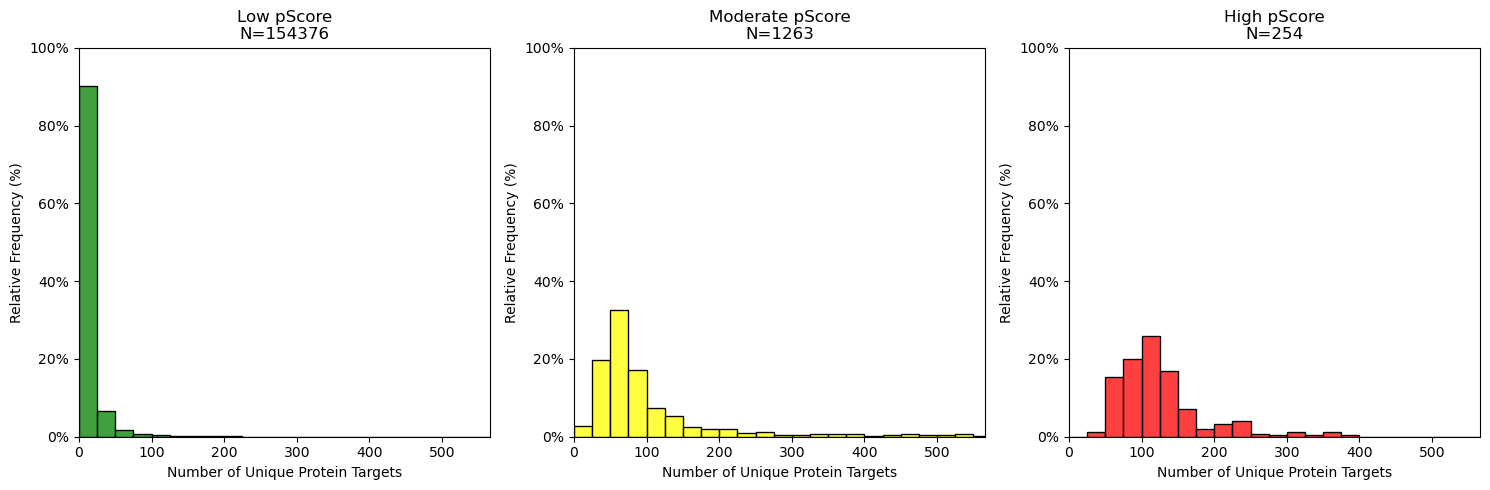

In [238]:
scaf_stats["pScore_category"] = scaf_stats["pscore"].apply(classify_pScore)

bins = np.arange(0, len(protein_target_df) + 25, 25) 

# Plot histograms
plt.figure(figsize=(15, 5))

categories = PSCORE_CATEGORIES
colors = ["green", "yellow", "red"]

for i, category in enumerate(categories):
    plt.subplot(1, 3, i+1)
    subset = scaf_stats[scaf_stats["pScore_category"] == category]
    sns.histplot(subset["unique_targets"], bins=bins, kde=False, color=colors[i], stat="percent")
    plt.title(f"{category}\nN={len(subset)}")
    plt.xlabel("Number of Unique Protein Targets")
    plt.ylabel("Relative Frequency (%)")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    plt.xlim(0, len(protein_target_df))
    plt.ylim(0, 100)

plt.tight_layout()
plt.show()

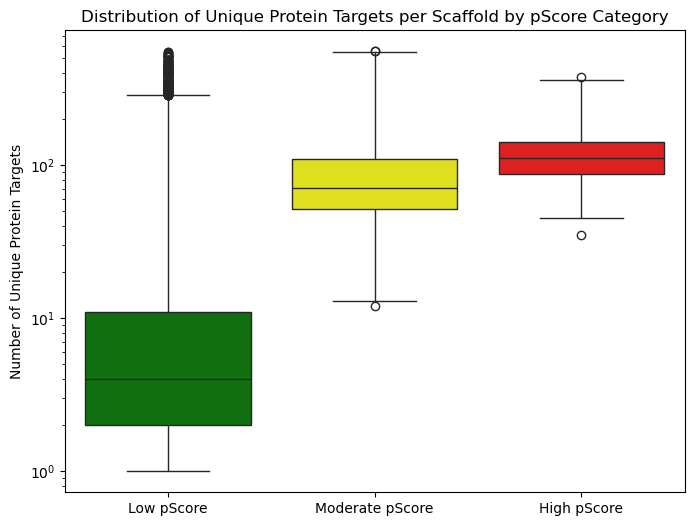

In [239]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=scaf_stats, x="pScore_category", y="unique_targets", hue="pScore_category", palette=colors, whis=(0.1,99.9))

# Formatting
plt.yscale("log")
plt.xlabel("")
plt.ylabel("Number of Unique Protein Targets")
plt.title("Distribution of Unique Protein Targets per Scaffold by pScore Category")

plt.show()

## Plot Unique Protein Families

In [240]:
protein_family_df = protein_target_df.dropna(subset=["protein_family"])[["target_id", "protein_family"]]

In [241]:
protein_family_df

,target_id,protein_family
2,3,Enzyme
3,4,GPCR
4,5,Enzyme
11,12,Enzyme
12,13,GPCR
...,...,...
591,592,Enzyme
592,593,Enzyme
593,594,Enzyme
594,595,Enzyme


In [242]:
scaf2fam_df = pd.merge(merged_df, protein_family_df, how="right", on="target_id")

In [243]:
scaf2fam_df

,scafid,target_id,pscore,protein_family
0,2,3,84.0,Enzyme
1,3,3,190.0,Enzyme
2,5,3,74.0,Enzyme
3,10,3,79.0,Enzyme
4,13,3,85.0,Enzyme
...,...,...,...,...
737991,467316,596,0.0,Enzyme
737992,467317,596,0.0,Enzyme
737993,467318,596,0.0,Enzyme
737994,467319,596,0.0,Enzyme


In [244]:
scaf_family_stats = scaf2fam_df.groupby("scafid").agg(
    unique_protein_families=("protein_family", lambda x: len(set(x))),
    pscore=("pscore", "first")
).reset_index()

In [245]:
scaf_family_stats["pScore_category"] = scaf_family_stats["pscore"].apply(classify_pScore)

In [246]:
scaf_family_stats

,scafid,unique_protein_families,pscore,pScore_category
0,1,8,23.0,Low pScore
1,2,9,84.0,Low pScore
2,3,9,190.0,Moderate pScore
3,5,9,74.0,Low pScore
4,7,9,100.0,Moderate pScore
...,...,...,...,...
120096,467316,1,0.0,Low pScore
120097,467317,1,0.0,Low pScore
120098,467318,1,0.0,Low pScore
120099,467319,1,0.0,Low pScore


In [247]:
family_set = set(protein_family_df["protein_family"])
total_n_families = len(family_set)
family_set # note that the TF; Epigenetic case accounts for N=2 proteins

{'Enzyme',
 'Epigenetic',
 'GPCR',
 'IC',
 'Kinase',
 'NR',
 'TF',
 'TF; Epigenetic',
 'Transporter'}

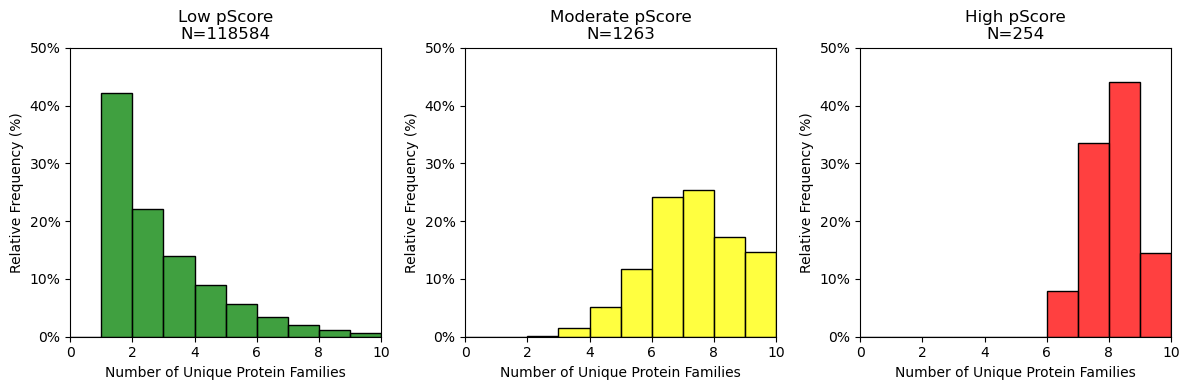

In [248]:
bins = np.arange(0, 11, 1) 
plt.figure(figsize=(12, 4))
for i, category in enumerate(PSCORE_CATEGORIES):
    plt.subplot(1, 3, i + 1)
    subset = scaf_family_stats[scaf_family_stats["pScore_category"] == category]
    sns.histplot(subset["unique_protein_families"], bins=bins, kde=False, color=colors[i], stat="percent")
    plt.ylabel("Relative Frequency (%)")
    plt.xlabel("Number of Unique Protein Families")
    plt.title(f"{category}\nN={len(subset)}")
    plt.gca().yaxis.set_major_formatter(PercentFormatter(xmax=100, decimals=0))
    plt.xlim(0, total_n_families + 1)
    plt.ylim(0, 50)
plt.tight_layout()
plt.show()

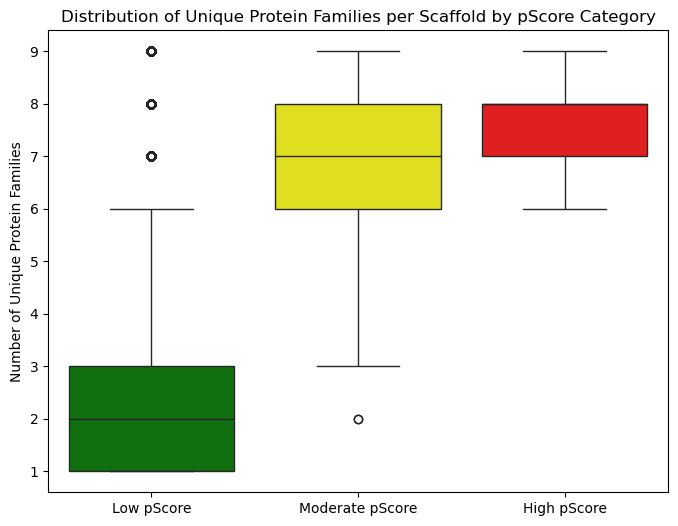

In [249]:
plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=scaf_family_stats, x="pScore_category", y="unique_protein_families", hue="pScore_category", palette=colors)

# Formatting
plt.yscale("linear")
plt.xlabel("")
plt.ylabel("Number of Unique Protein Families")
plt.title("Distribution of Unique Protein Families per Scaffold by pScore Category")

plt.show()

# Close DB Connection

In [250]:
# Close the cursors
db_cur.close()

# Close the connections
db_connection.close()